In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import itertools
import pickle
from collections import defaultdict
from IPython.display import HTML
import tensorflow as tf
try:
    import keras
except ModuleNotFoundError:
    from tensorflow import keras
print('GPU:', tf.test.is_gpu_available())

# Catch

Let's train a model to play catch using a similar algorithm to the one we used from [tic-tac-toe](../sessions/reinforcement.ipynb).

We start with functions to display the board and update the board.

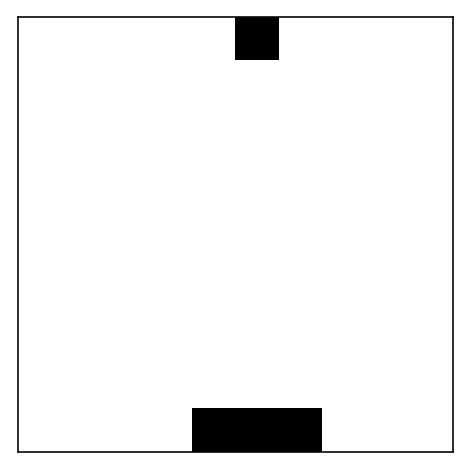

In [21]:
def display(board, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    ax.imshow(board, cmap='gray_r')
    ax.set(xticks=[], yticks=[])

def create_board(size):
    board = np.zeros((size, size), dtype='int')
    n = size//2
    board[0, n] = 1 # rock
    board[-1, n-1:n+2] = 1 # basket
    
    return board

size = 10
board = create_board(size)
display(board)

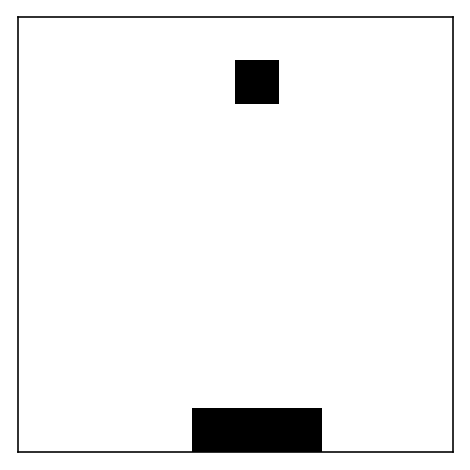

In [22]:
def update_rock(board): # to increase difficulty, have to rock randomly jump right and left
    i, j = np.array(board[:-1,:].nonzero()).squeeze()
    board[i, j] = 0
    board[i + 1, j] = 1

update_rock(board)
display(board)

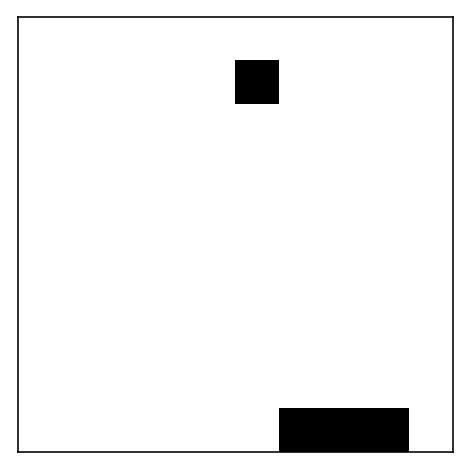

In [51]:
def update_basket(board, move):
    assert -1 <= move <= 1
    if move == 0: return
    j = board[-1, :].argmax() + 1
    left, right = j-1, j+2
    if left + move < 0:
        move = 0
    elif right + move > board.shape[1]:
        move = 0
    j += move
    board[-1, :] = 0
    board[-1, j-1:j+2] = 1
    
update_basket(board, 1)
display(board)

The next function displays a series of boards to show a full game.

In [24]:
def display_game(boards):
    size = len(boards)
    fig, axes = plt.subplots(size, 1, figsize=(3, 3*size))
    for board, ax in zip(boards, axes):
        display(board, ax=ax)

This function calculates the reward, which is simply 1 for success and -1 for failure.

In [25]:
def get_reward(board):
    if board[-1, :].sum() == 3:
        return 1
    else:
        return -1

We create a random model to fill in for the model you'll create later.

In [113]:
class RandomModel:
    def predict(*args):
        return (np.ones(3) / 3).reshape((1, -1))
    def train_on_batch(*args):
        return -np.inf

model = RandomModel()

This function plays a full game using the model. With probability $\epsilon$ we explore new moves; otherwise we use the model prediction.

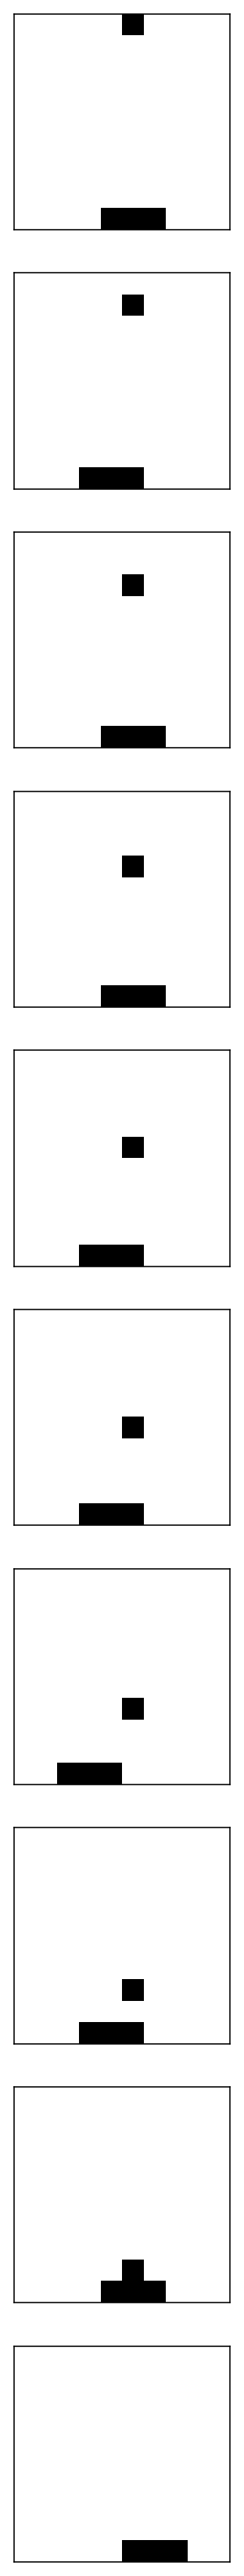

In [114]:
def play_game(size, ϵ=0.1):
    board = create_board(size)
    boards = [None for _ in range(size)]
    moves = [0] * size
    
    for t in range(size):
        boards[t] = board.copy()
            
        if np.random.rand() < ϵ:
            pred = np.ones(3) / 3
        else:
            pred = model.predict(board.reshape(1,-1)).ravel() # predict gives (1, 3)
        move = np.random.multinomial(1, pred).argmax() - 1 # multinomial returns 0, 1 ,2
        moves[t] = move
        update_basket(board, move)
        update_rock(board)
    
    return boards, moves

boards, moves = play_game(size)
display_game(boards)

This functions scores the model, calculating the fraction of wins.

In [115]:
def score(size, reps=100):
    boards = [play_game(size, ϵ=0)[0][-1] for _ in range(reps)]
    scores = np.array([get_reward(b)==1 for b in boards])
    return scores.mean()

print('Score', score(size))

Score 0.49


This function trains the model on a single game it played.

In [116]:
def train_on_game(boards, moves, δ=0.9):
    # δ is a discounting parameter
    reward = get_reward(boards[-1])
    X = np.empty((len(boards), size*size))
    Y = np.empty((len(boards), 3))
    for t, (board, move) in enumerate(zip(boards, moves)):
        X[t] = board.reshape(size*size)
        Y[t] = np.zeros(3)
        Y[t, move+1] = reward * δ**(len(moves) - t - 1) # move is -1 0 or 1
    loss = model.train_on_batch(X, Y)
    return loss

Now everything is ready. 

**Create your model, train it, and score it.**

In [190]:
# your code here

In [191]:
losses = []
scores = []
print('Score before training:', score(size, reps=1000))

Score before training: 0.417


The train function runs `num_of_games` games, and prints the score after every 1000 games.

In [194]:
def train(num_of_games=1000, verbose=True):
    for i in range(1, num_of_games+1):
        boards, moves = play_game(size)
        loss = train_on_game(boards, moves)
        if i % 100 == 0:
            losses.append(loss)
            if verbose: print("loss={}".format(loss))
        if i % 1000 == 0:
            scores.append(score(size))
            if verbose: print('Score', scores[-1])

In [ ]:
train()

This will plot the score and loss over training time.

In [ ]:
plt.plot(np.linspace(0, len(losses)*10, len(scores)), scores, label='score')
plt.plot(np.linspace(0, len(losses)*10, len(losses)), losses, label='loss')
plt.legend()
plt.xlabel('Games');

# Colophon
This notebook was written by [Yoav Ram](http://python.yoavram.com) and is part of the [_Data Science with Python_](https://github.com/yoavram/DataSciPy) workshop.

The notebook was written using [Python](http://python.org/) 3.6.5.

This work is licensed under a [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/) International License.

![Python logo](https://www.python.org/static/community_logos/python-logo.png)